# Goals

Build a model to predict conversion rate and come up with a way to improve revenue 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

/home/quantran/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
import seaborn as sns

In [4]:
PATH = Path('data/conversion_data.csv')

In [7]:
df = pd.read_csv(PATH)

In [8]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [9]:
df.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [10]:
df.isnull().sum(axis=0)

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

# Single feature exploration/preprocess

## country

CategoricalDtype(categories=['China', 'Germany', 'UK', 'US'], ordered=False)

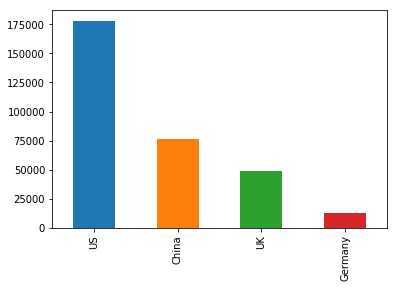

In [11]:

df.country = df.country.astype('category')
df.country.dtypes
df.country.value_counts().plot(kind='bar')

Text(0.5,1,'Conversion rate = 1')

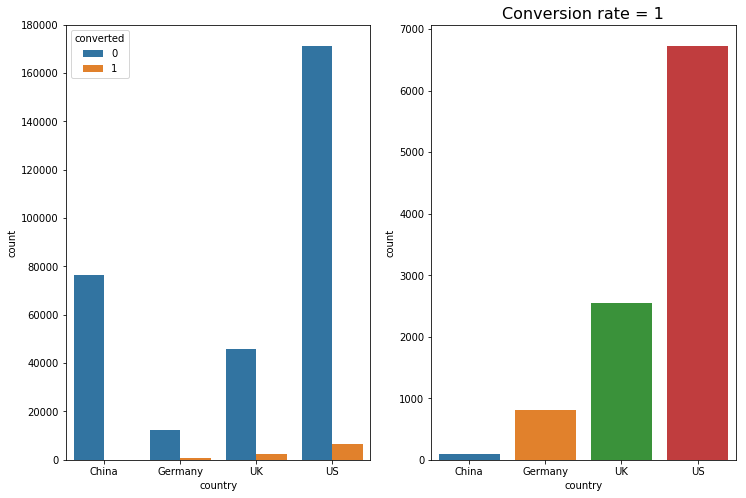

In [12]:
f,axes = plt.subplots(1,2,figsize=(12,8),sharex=True)
sns.countplot(x='country',hue='converted',data=df,ax=axes[0])
sns.countplot(x='country',data=df[df.converted==1],ax=axes[1])
axes[1].set_title('Conversion rate = 1', fontsize=16)

China has the lowest conversion rate

## Age

count    316200.000000
mean         30.569858
std           8.271802
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max         123.000000
Name: age, dtype: float64

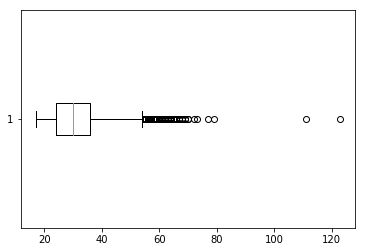

In [13]:

_=plt.boxplot(df.age,vert=False)
df.age.describe()

In [14]:
# get outliers
# iqr = df.age.quantile(q=0.75) - df.age.quantile(q=0.25)
# lower = df.age.quantile(q=0.25) - iqr*1.5
# upper = df.age.quantile(q=0.75) + iqr*1.5
# lower,upper

In [15]:
df[df.age>=80]
# Interesting to see these 2 users are converted. Class label 'converted' is highly imbalanced.

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [16]:
df.drop(df[df.age>=80].index,inplace=True)

/home/quantran/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


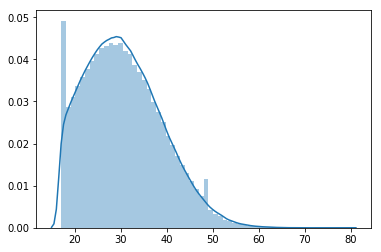

In [17]:
sns.distplot(df.age.values,bins=60,kde=True)

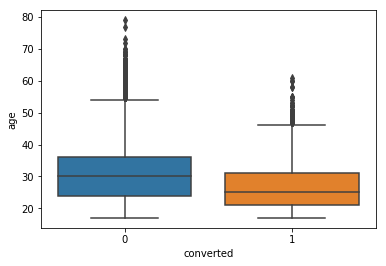

In [18]:
sns.boxplot(x='converted',y='age',data=df)

## new_user

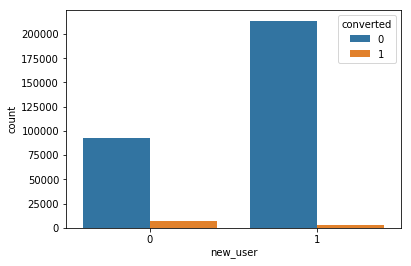

In [19]:
sns.countplot(x='new_user',hue='converted',data=df)
# df.new_user.value_counts().plot(kind='bar')

Ratio of new converted user/new non-coverted user is a lot of smaller than its counterpart; there are a lot more new users coming but not many of them convert.

## source

Text(0.5,1,'Conversion rate = 1')

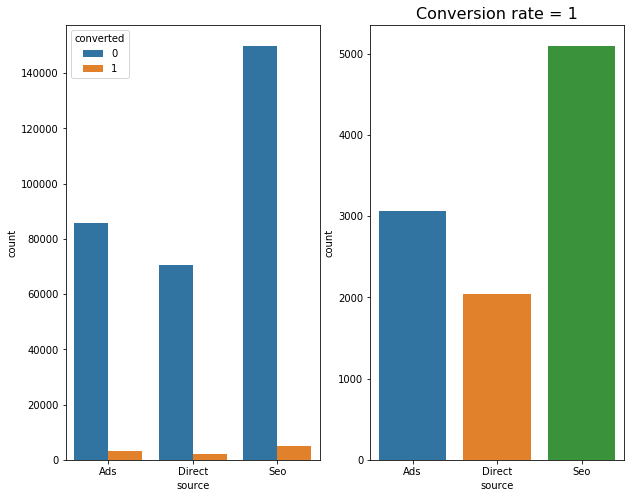

In [20]:
df.source = df.source.astype('category')
f,axes = plt.subplots(1,2,figsize=(10,8),sharex=True)
sns.countplot(x='source',hue='converted',data=df,ax=axes[0])
sns.countplot(x='source',data=df[df.converted==1],ax=axes[1])
axes[1].set_title('Conversion rate = 1', fontsize=16)
# df.source.value_counts().plot(kind='bar')

## total page visited

count    316198.000000
mean          4.872918
std           3.341053
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          29.000000
Name: total_pages_visited, dtype: float64

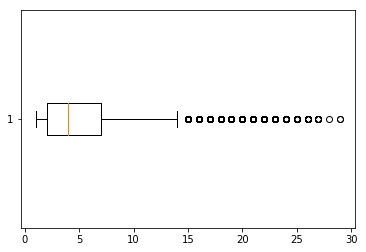

In [21]:

_=plt.boxplot(df.total_pages_visited,vert=False)
df.total_pages_visited.describe()

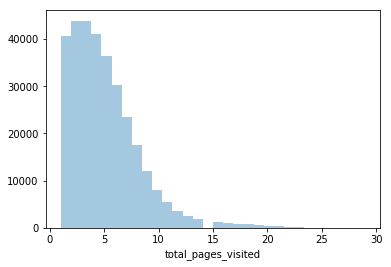

In [22]:
sns.distplot(df.total_pages_visited,bins=30,kde=False)

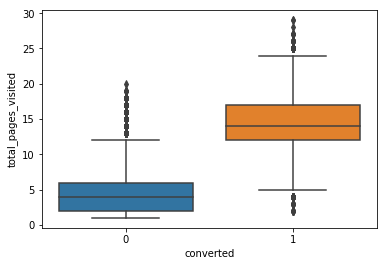

In [23]:
sns.boxplot(x='converted',y='total_pages_visited',data=df)

There is a somewhat clear division between conversion rate based on total pages visited: people are less likely to convert when they visit <=7 pages (>50% of people who dont convert), and people are more likely to convert when they visit >= 10 pages (>50% of people who convert)

# dependent var

In [24]:
y = df.converted

In [25]:
(y.value_counts() / len(y) )*100

0    96.774806
1     3.225194
Name: converted, dtype: float64

Classification problem with inbalanced class

# Multiple features exploration

Since we have only 5 independant features and only 2 of them are categorical and they are not sparse, we can apply one hot encoding and thus can see the contribution of each category better.

In [26]:
# downcast some numerical fea
cat = ['country','source']
for col in df.columns.values:
    if col not in cat: df[col]=df[col].astype(np.uint8)

In [27]:
df_dummy = pd.get_dummies(df)

In [28]:
df_dummy.dtypes

age                    uint8
new_user               uint8
total_pages_visited    uint8
converted              uint8
country_China          uint8
country_Germany        uint8
country_UK             uint8
country_US             uint8
source_Ads             uint8
source_Direct          uint8
source_Seo             uint8
dtype: object

In [29]:
corrmat = df_dummy.corr(method='pearson')
# pearson correlation

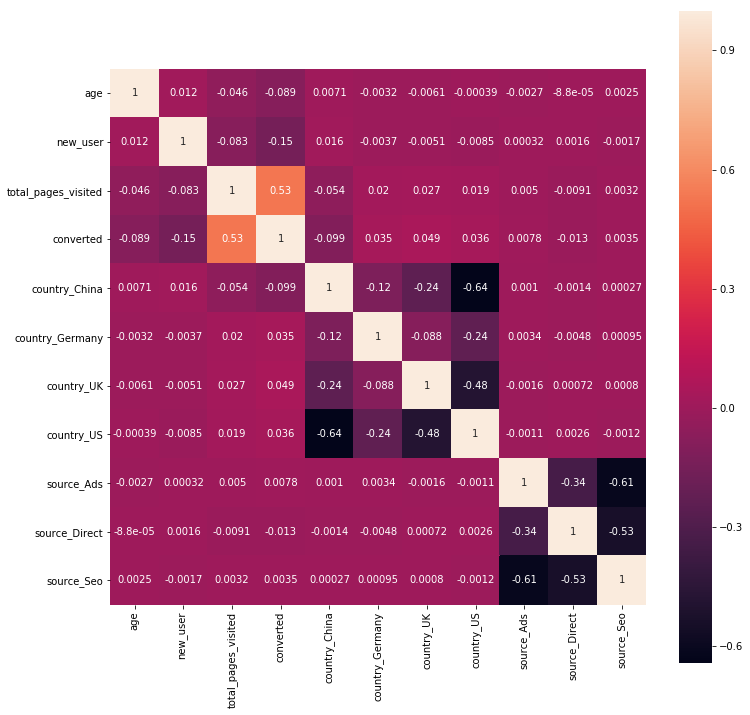

In [30]:
f,ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,square=True,annot=True)

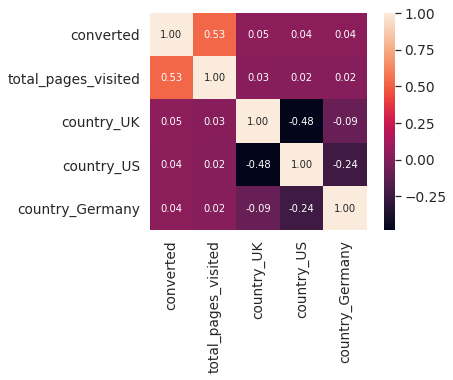

In [31]:
# top 5 features with high pearson correlation against class label 'converted'

k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'converted')['converted'].index
cm = np.corrcoef(df_dummy[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


Beside total_pages_visited, no other features has > .5 correlation with class label. Dependent features don't correlate with each other, thus we have a little-to-zero multicolinear dataset

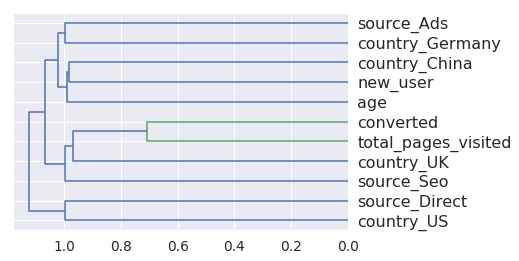

In [32]:
#another way to see feature correlation: draw dendrogram of spearman rank correlation
import scipy
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_dummy).correlation,4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed,method='average')
# fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z,labels = df_dummy.columns,orientation='left',leaf_font_size=16)
plt.show()

As expected, total_pages_visited and converted are the 2 highest correlated feature in this dataset (marked by green lines)

# Machine learning

Since one of the goal is to predict AND give recommendation to improve conversion rate, we can choose type of model that can produce feature importances. For this dataset, 2 models to be considered are: logistic regression and random forest (decision tree based)
- Logistic regression: simple, easy to intepret. Dataset has low level of multicollinearity. Extract feature importance from coefficient. Note: data has to be scaled before use.
- Random Forest: an improvement from logistic regression. More powerful, a little harder to intepret. RF can extract useful feature interaction. RF can also show feature interaction with single tree plot. Extract feature importance using permutation importance (instead of gini importance from sklearn)

## Evaluation

Since this is an imbalanced classification problem, using accuracy metric might not be a good idea as a simple baseline model of predicting non-conversion all the time can result in 96% accuracy. With imbalanced dataset, 2 suggestions for metrics are:
- precision/recall (f1 score): weighted average between precision and recall. This is a safe choice as we are not sure whether precision or recall is more important for this dataset. Either way, this metric is more suitable for imbalanced dataset than accuracy. Best F1 score is at 1, worst at 0. 

- AUROC (area under receiver operating characteristic curve), sometimes referrered as ROC AUC or just AUC. This metric takes into account true positive rate (recall) and false positive rate. Best at 1, worst at 0.5 (random prediction)



## Data preparation

In [5]:

num_features = ['age','total_pages_visited']
cat_features = ['country','source']
bool_features=['new_user']
def prepare_data():
    df = pd.read_csv(PATH)
    df.drop(df[df.age>=80].index,inplace=True)
    # downcast num feature, cast category type for cat feature   
    for col in df.columns.values:
        if col in num_features: df[col]=df[col].astype(np.uint8)
        if col in cat_features+bool_features: df[col]=df[col].astype('category')
#     df= pd.get_dummies(df)
    return df

In [6]:
df = prepare_data()

In [7]:
df.head()
df.dtypes

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


country                category
age                       uint8
new_user               category
source                 category
total_pages_visited       uint8
converted                 int64
dtype: object

## Split data

In [9]:
seed=1204
import random
random.seed(seed)

We will hold out 10% of data as final test data. We will only use this data for model's final evaluation

In [10]:
from sklearn.model_selection import train_test_split

def test_split(df,seed):
    X,X_test,y,y_test = train_test_split(df,df.converted,test_size=.10,random_state=seed)
    X = X.drop('converted',axis=1).reset_index(drop=True)
    X_test = X_test.drop('converted',axis=1).reset_index(drop=True)
    y,y_test = y.reset_index(drop=True), y_test.reset_index(drop=True)
    return X,X_test,y,y_test

In [11]:
X,X_test,y,y_test = test_split(df,seed)

# Baseline evaluation

In [12]:
from sklearn.metrics import f1_score,roc_auc_score

In [13]:
# for roc_auc_score, use probability of positive class for all prediction
y1_prob=len(y[y==1])/len(y)
y1_prob

0.03213178812135865

In [14]:
y_test_pred = np.array([y1_prob]*len(y_test))
roc_auc_score(y_test,y_test_pred)

0.5

In [15]:
# few scenario for f1 score baseline
y_test_pred = np.random.choice(2,len(y_test),p=[1-y1_prob,y1_prob])
f1_score(y_test,y_test_pred)

y_test_pred = np.random.choice(2,len(y_test),p=[0.5,0.5])
f1_score(y_test,y_test_pred)

0.03070827142149579

0.06022659511031605

# Logistic Regression

## Prepare preprocess pipeline for logistic regression

In [16]:
# building pipeline
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import DataConversionWarning
import warnings
class LRPreparer(BaseEstimator, TransformerMixin):
#     def __init__(self):    
    def fit(self,X,y=None):
        warnings.filterwarnings('ignore', category=DataConversionWarning)
        map_f = [([n],StandardScaler()) for n in X.columns if n in num_features]
        self.mapper = DataFrameMapper(map_f).fit(X)
        return self
    def transform(self,X):
        X_tr = X.copy()
        X_tr[self.mapper.transformed_names_] = self.mapper.transform(X_tr)
        X_tr = pd.get_dummies(X_tr,columns=cat_features)
        return X_tr

In [64]:
# testing transform function
tfms = LRPreparer()
tfms.fit(X)

LRPreparer()

In [65]:
temp = tfms.transform(X)
temp.head()

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,-0.190261,1,0.037922,0,1,0,0,1,0,0
1,-1.520258,0,-0.261592,0,0,0,1,1,0,0
2,-0.190261,1,0.337436,0,0,1,0,0,0,1
3,-0.311169,1,-0.860620,1,0,0,0,1,0,0
4,-0.069352,0,0.636950,0,0,0,1,1,0,0


## Logistic Regression

We will use stratified cross validation (5 fold) for a better evaluation of this model

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

In [53]:
k=5
cv = StratifiedShuffleSplit(n_splits=k, test_size=0.3, random_state=seed)
lr = LogisticRegression(penalty='l2',C=1,class_weight=None)
ppr = LRPreparer()
clf = make_pipeline(ppr,lr)
scoring=['roc_auc','f1']


In [54]:
scores = cross_validate(clf,X,y,scoring=scoring,cv=cv,return_train_score=True,
                       n_jobs=-1)

In [48]:
def intepret_score(scores):

    def plot_score(ax,idx,train,val,score_name):
        ax.scatter(idx+1,train,marker='o',color='g',label='train')
        ax.scatter(idx+1,val,marker='o',color='r',label='val')
        ax.plot(idx+1,[np.mean(val)]*len(idx),linestyle='-',color='orange',label='val mean')
        ax.set_xlabel('fold')
        ax.set_title(score_name)
        ax.legend()
        ax.set_ylim([min(min(train),min(val))-0.001,max(max(train),max(val))+0.001])
    fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True)
    bar_width = 0.35
    opacity = 0.8
    
    idx = np.arange(k)
    train_f1 = scores['train_f1']
    val_f1 = scores['test_f1']
    plot_score(ax[0],idx,train_f1,val_f1,'f1')
    
    train_auc = scores['train_roc_auc']
    val_auc = scores['test_roc_auc']
    plot_score(ax[1],idx,train_auc,val_auc,'roc_auc')
    
    return {'f1_val_mean': np.mean(val_f1),'auc_val_mean':np.mean(val_auc)}
    

{'f1_val_mean': 0.7620614188857431, 'auc_val_mean': 0.9858986430821611}

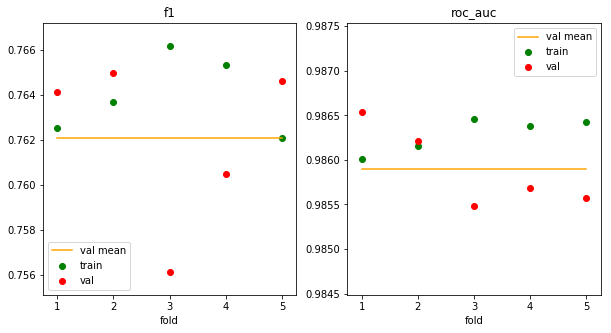

In [55]:
# no class weight
intepret_score(scores)

There are not much difference in auc score (right graph) between training and validation set, which means the model does not overfit. In some fold validation score is a bit better than training score, which is a sign of underfitting. Unfortunately, decreasing l2 regularization by increasing C parameter does not change the result, thus we can conclude logistic regression has reached its limit for this dataset. 

{'f1_val_mean': 0.5088695007966645, 'auc_val_mean': 0.9858917079283465}

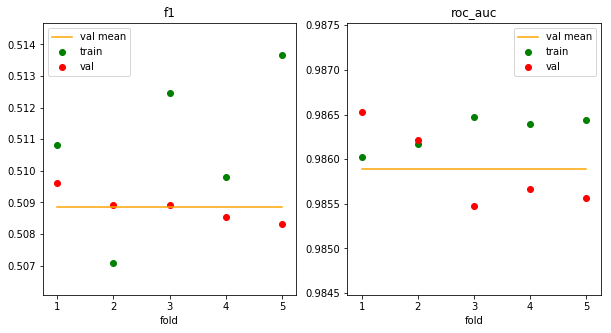

In [52]:
# class weight = balanced
intepret_score(scores) # C=1

Interesting that when tuning 'class_weight' parameter of sklearn logistic regression, choosing 'balanced' results in worst f1 score but not AUC score. Setting class_weight = 'balanced adjusts weights inversely proportional to class frequencies in the input data, which is thought to be better for imbalanced dataset.

## Evaluating logistic regression + feature importance

In [56]:
# let train on whole dataset and predict on test set
k=5
lr = LogisticRegression(penalty='l2',C=1)
ppr = LRPreparer()
clf = make_pipeline(ppr,lr)

In [57]:
clf.fit(X,y)

Pipeline(memory=None,
     steps=[('lrpreparer', LRPreparer()), ('logisticregression', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [58]:
y_test_predict=clf.predict(X_test)
y_test_predict_proba = clf.predict_proba(X_test)

In [61]:
y_test_predict_proba[:,1]

array([5.84269800e-04, 7.17215934e-03, 7.00443524e-04, ...,
       1.48746129e-01, 4.44428809e-05, 5.28974332e-05])

In [62]:
print('ROC AUC on test set')
roc_auc_score(y_test,y_test_predict_proba[:,1])

ROC AUC on test set


0.9849131955847309

In [63]:
print('F1 on test set')
f1_score(y_test,y_test_predict)

F1 on test set


0.7572712850343735

In [66]:
y_test_predict[y_test_predict==1].shape

(837,)

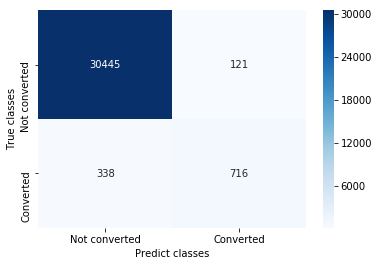

In [65]:
# confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    labels=['Not converted','Converted']
    sns.heatmap(cm,cmap='Blues',xticklabels=labels,yticklabels=labels,annot=True,fmt=".0f")
    plt.ylabel('True classes')
    plt.xlabel('Predict classes')
plot_confusion_matrix(y_test,y_test_predict)

Logistic regression model have high precision and recall score (.996 and .989). False positive 121 cases < False negative 338 cases. For all converted customer in test set (1054), the model can identify 716 of them correctly (~70%).

Let's take a deeper look at model's coefficient

In [73]:
cols = ppr.transform(X_test).columns.values

In [83]:
f_importance = pd.DataFrame({'cols': cols,'coeff':lr.coef_[0]})
f_importance['is_positive'] = f_importance.coeff >=0
f_importance.coeff = np.abs(f_importance.coeff)
f_importance.sort_values('coeff',inplace=True,ascending=False)
# f_importance

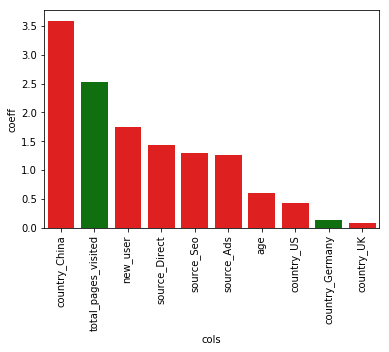

In [82]:
clrs = ['red' if not x else 'green' for x in f_importance.is_positive ]
s=sns.barplot(x="cols", y="coeff", palette=clrs,data=f_importance)
plt.setp(s.get_xticklabels(),rotation=90);

The higher the column's coefficient magnitude, the more contribution it has toward predicting the label. Negative coefficient (red) contributes toward predicting negative class (non-converted)  and positive coefficient (green) contributes toward positive class.

From this graph, we can see that 
- China's conversion rate is really low (We can also see this in Country vs Conversion Rate bar plot above). As China is the second largest group of users from this dataset, if we can improve website content and tailor it to Chinese customers, conversion rate should increase. On this dataset, we can extract them into a smaller set to study separately
- Total pages visited is another important feature, which seems obvious: if users visit more sites, they engaged more into our content thus they are more likely to convert. We can keep this up by improving site content to increase site visits and/or send coupons to those who visit a certain number of sites to encourage them to convert
- We can also expect a small increase of conversion rate when considering other single feature (why new users are less likely to convert? why are young people 20-25 more likely to convert?), but to see how features interact with each other, it's better to use decision tree based method, such as Random Forest. With RF, we can dig deeper into a specific record or a specific group to see which features have the most effect so we can recommend specialized solutions